# Part 1: Initial data preparation

In [7]:
# import required packages
import pandas as pd
 #!pip install pandas fiona shapely pyproj rtree
#!pip install pandas fiona shapely pyproj rtree
#!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#!pip install rasterio
#import rasterio
#from rasterio.plot import show
import os
import numpy as np
from shapely.geometry import LineString
from shapely.ops import unary_union
%config InlineBackend.figure_format='retina'


In [2]:
# these are survey data streamlines
jsonfiles = os.listdir('../data/Ramsey/wetdry/survey_data')

In [3]:
# import data files
geodata = {f:0 for f in jsonfiles}
for f in jsonfiles:
  print(f)
  df = gpd.read_file('https://raw.githubusercontent.com/lapidesd/'+
                     'SanPedro_wetdry_pilot/main/data/Ramsey/wetdry/survey_data/'+f).to_crs('EPSG:26912')
  geodata[f] = df

# wetted channel surveys
surveylist = [geodata[key] for key in jsonfiles]

# get geomorphic channel points for surveyed reach every 5 m
survey_boundary = gpd.read_file('../data/Ramsey/ramsey_streamline.shp').to_crs('EPSG:26912')
survey_boundary_geom = survey_boundary['geometry'].unary_union
distance_delta = 5 # point every 5 m along line
distances = np.arange(0,survey_boundary_geom.length, distance_delta)
points = [survey_boundary_geom.interpolate(distance) for distance in distances]+[survey_boundary_geom.boundary.geoms[-1]]
# multipoint = unary_union(points)
geomorph = gpd.GeoDataFrame(pd.DataFrame.from_dict({'p':[0]*len(points)}),geometry=points).set_crs('EPSG:26912')

6-15-2015.geojson
6-15-2023.geojson
6-15-2022.geojson
6-15-2014.geojson
6-15-2020.geojson
6-15-2016.geojson
6-15-2021.geojson
6-15-2012.geojson
6-15-2013.geojson
6-15-2018.geojson
6-15-2009.geojson
6-15-2019.geojson
6-15-2010.geojson


# Section 1: DO NOT RUN : Put together a dataset of nodes with PlanetScope data
This cannot be run in Colab (would take days), and PlanetScope data is not available in the data supplement

In [ ]:
# get list of imagery rasters available
imagery_location = '../../Ramsey/imagery/data_use/'
rasters = os.listdir(imagery_location)
rasters = [r for r in rasters if r.endswith('SR_clip.tif')]

In [ ]:
# function to extract PlanetScope zonal stats in buffer (buffer=True)
# around geomorphic channel
# or at geomorphic channel point (buffer=False)
def query_raster(x,y, # GPS point
                 point1, # GPS point (geometry type)
                 raster, # satellite imagery
                 buffer): # buffer area (# pixels) around channel point to grab data from
    r = raster
    band_data = {'blue':0,
                   'geometry':0,
                   'green':0,
                   'red':0,
                  #  'rededge':0,
                   'NIR':0,
                #  'Yellow':0,
                #  'GreenI':0,
                #  'CoastalBlue':0,
                 'missing':0}
    missing = 0
    row, col = r.index(x,y) # find location of the gps point (x,y) in the raster image
    if buffer:
      rs = list(range(row-1,row+2))
      cs = list(range(col-1,col+2))
    else:
      rs = [row]
      cs = [col]
    try:
      blues = []
      greens = []
      reds = []
      # rededges = []
      nirs = []
      for row in rs:
        for col in cs:
          blues.append(raster.read(1)[row,col])
          greens.append(raster.read(2)[row,col])
          reds.append(raster.read(3)[row,col])
          # rededges.append(raster.read(4)[row,col])
          nirs.append(raster.read(4)[row,col])

      band_data['blue'] = np.nanmean(blues)
      band_data['geometry'] = point1
      band_data['green'] = np.nanmean(greens)
      band_data['red'] = np.nanmean(reds)
      # band_data['rededge'] = np.nanmean(rededges)
      band_data['NIR'] = np.nanmean(nirs)
    except:
      missing = 1
    band_data['missing'] = missing
    return (band_data)

In [ ]:
geomorph.crs

In [ ]:
# very slow --ran on local machine

# gdfs = []
!pip install multiprocess
gdf = geomorph
gdf['x'] = gdf.to_crs('EPSG:26912').geometry.x
gdf['y'] = gdf.to_crs('EPSG:26912').geometry.y
import rasterio
def query_buffer(args):
    cpu,cpus,rasters = args
    for i in range(int(cpu/cpus*len(rasters)),int((cpu+1)/cpus*len(rasters))): # separate rasters onto separate cores
        # print(i)
        r1 = rasters[i]
        #   print(i,'of',len(rasters))
        date = r1.split('_')[0]
        r = rasterio.open(imagery_location+r1)
        out = gdf.apply(lambda row:query_raster(row.x,row.y,row.geometry,
                                                                     r,buffer = True),axis=1)
        keys = list(out.values[0].keys())
        try:
            band_data = pd.DataFrame.from_dict({keys[j]:[out.values[i][keys[j]] for i in range(len(out))]
                                  for j in range(len(keys))})
            band_data = band_data[band_data.missing==0]
            band_data = gpd.GeoDataFrame(
              band_data, geometry=band_data.geometry).set_crs('EPSG:26912')
            band_data['NDWI'] = (band_data.green-band_data.NIR)/(band_data.green+band_data.NIR)
            g = gpd.sjoin(band_data,gdf,how='left')
            g = g.drop_duplicates().drop(columns='index_right')
            g['date'] = date
            g.to_file('../../Ramsey/imagery/buffer/'+r1[:-4]+'.tif')
        except:
            print('no geoms for',r1)
    return

import multiprocess as mp
import sys


cores = 8
import time
start_time = time.time()
sys.stdout.write('\r\n')
arguments = []
for cpu in range(0,cores):
    arguments.append((cpu,cores,rasters))
pool = mp.Pool()
results = pool.map(query_buffer, arguments)
# r = query_buffer(arguments[0])
extime = time.time()-start_time
print(extime)

In [ ]:
gdfs = []
for i in range(len(rasters)):
    r = rasters[i]
    print(i,' of',len(rasters))
    try:
        g = gpd.read_file('../../Ramsey/imagery/buffer/'+r[:-4]+'.tif/'+r[:-4]+'.shp')
        gdfs.append(g)
    except:
        print('skipping '+r)
gdf_predict = pd.concat(gdfs)

In [ ]:

# gdf_predict['x'] = gdf_predict.to_crs('EPSG:4326').geometry.x*1000
# gdf_predict['y'] = gdf_predict.to_crs('EPSG:4326').geometry.y*1000

start = 0
splitnum = 20
for i in range(1,splitnum+1):
    newstart = int(len(gdf_predict)/splitnum*i)
    gdf_predict.iloc[start:newstart].drop(columns=['x','y']).to_csv('../data/Ramsey/processed_imagery/PSScope_data_buffer_'+str(i)+'.csv',index=False,
                      float_format='%.2f')
    start = newstart

In [ ]:
# gdf_predict = pd.concat(gdfs)
# gdf_predict['date'] = pd.to_datetime([s[:4]+'-'+s[4:6]+'-'+s[6:] for s in gdf_predict['date']])
# # gdf_predict.to_csv('../data/Ramsey/imagery/processed_imagery/PSScope_data_buffer.csv',index=False)

In [ ]:
pd.read_csv('../data/Ramsey/processed_imagery/PSScope_data_buffer_1.csv',)

# Put together a dataset for training the random forest model

In [4]:
import shapely
surveyed = gpd.read_file('../data/Ramsey/wetdry/RamseyExport/Surveyed_Ramsey_1999_2023.shp')
surveyed['Year'] = surveyed.Year.astype('int')
wet = gpd.read_file('../data/Ramsey/wetdry/RamseyExport/Wet_Ramsey_1999_2023.shp')
wet['Year'] = surveyed.Year.astype('int')
wet['wetdry'] = 'wet'
drysegments = []
for y in surveyed.Year.unique():
    wetyr = wet[wet.Year==y].geometry.unary_union
    surveyyr = surveyed[surveyed.Year==y].geometry.unary_union
    dryyr = surveyyr.difference(shapely.buffer(wetyr,.1))
    drysegments.append(dryyr)
dry = pd.DataFrame.from_dict({'Year':surveyed.Year.unique(),
                              'geometry':drysegments})
dry = gpd.GeoDataFrame(dry,geometry=dry.geometry)
dry['wetdry'] = 'dry'
wetdry = pd.concat([wet,dry])

/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83(HARN) / UTM zone 12N (the single non-null crs provided).
  warnings.warn(


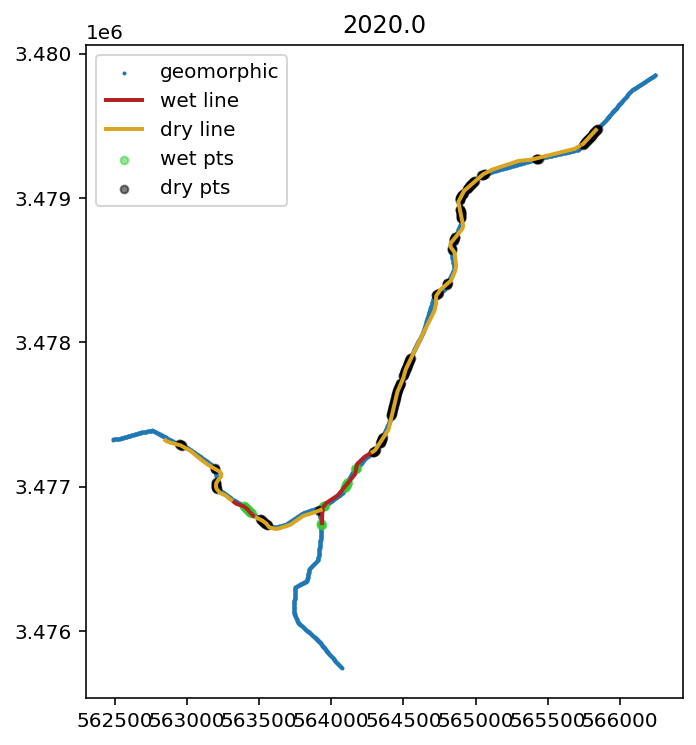

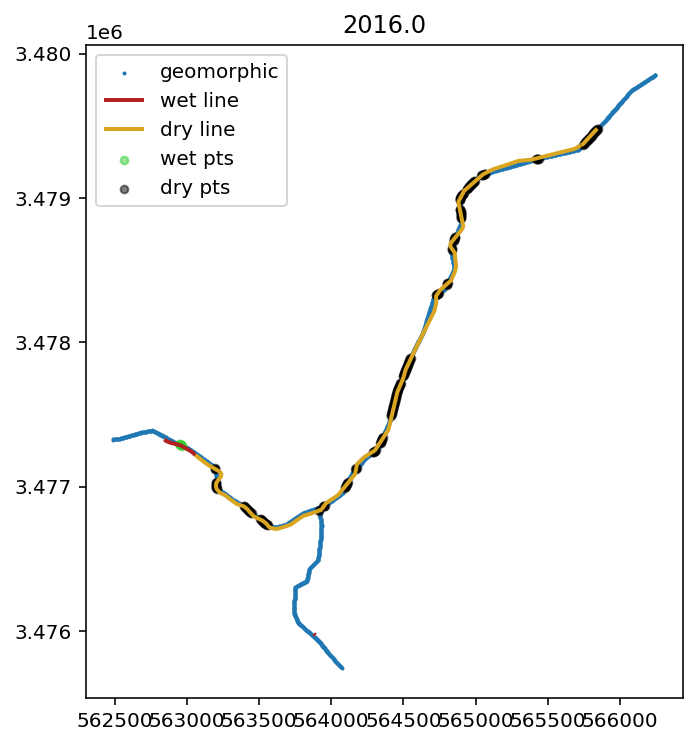

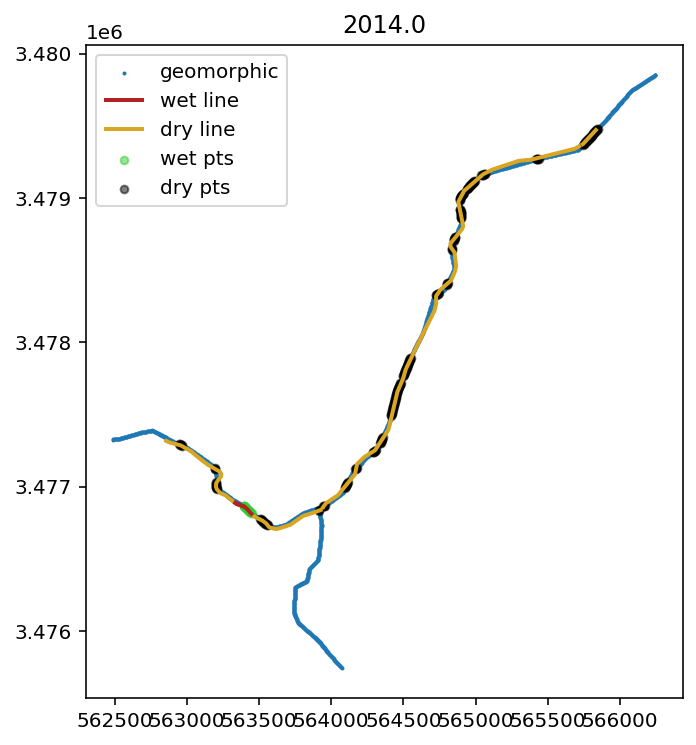

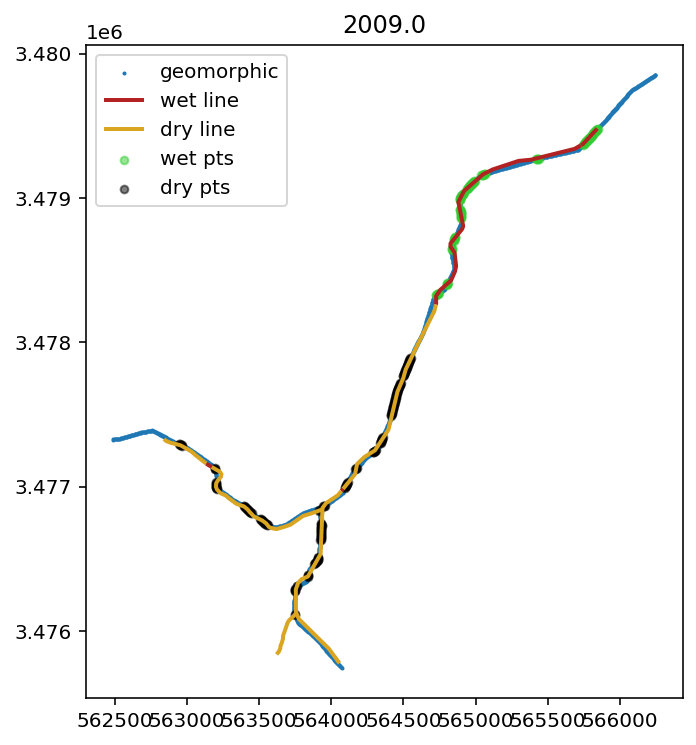

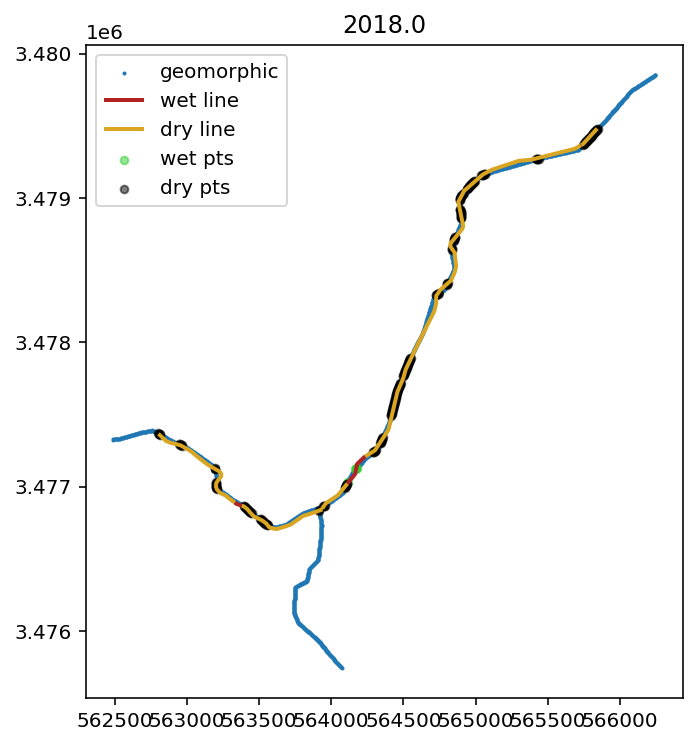

In [10]:
d = 5 # m, max distance for error in merge-->this is too big
surveyData = []

for y in wetdry.Year.unique()[:5]:
    wsub = wetdry[(wetdry.Year==y) ].to_crs('EPSG:26912')
    # dsub = wetdry[(wetdry.Year==y) & (wetdry.wetdry=='dry')].to_crs('EPSG:26912')
    wetpts = gpd.sjoin_nearest(geomorph, wsub, max_distance=d,)
    wetpts['Year'] = y
    surveyData.append(wetpts)
    drypts = wetpts[wetpts.wetdry=='dry']
    wetpts = wetpts[wetpts.wetdry=='wet']
    # drypts = gpd.sjoin_nearest(geomorph, dsub, max_distance = d)
    fig,ax = plt.subplots(1,figsize = (6,6))
    geomorph.plot(ax=ax,markersize=1,label='geomorphic')
    wsub[wsub.wetdry=='wet'].plot(edgecolor = 'firebrick',ax=ax,label='wet line',lw=2)
    wsub[wsub.wetdry=='dry'].plot(edgecolor = 'goldenrod',ax=ax,label='dry line',lw=2)
    wetpts.plot(ax=ax,c='limegreen',markersize = 15,label='wet pts',alpha=.5)
    drypts.plot(ax=ax,c='k',markersize = 15, label='dry pts',alpha=.5)
    ax.legend()
    ax.set_title(y)
    plt.show()

surveyData =pd.concat(surveyData)[['geometry','Year','wetdry']]

In [ ]:
# # ignore this. my code is not tidy

# numdone = len(os.listdir('../../Cienega/data/Imagery/buffer'))
# numtodo = os.listdir('../../Cienega/data/Imagery/PSScene/')
# numtodo = [p for p in numtodo if p.endswith('SR_clip.tif')]
# numtodo = len(numtodo)
# print(str(numdone)+' of '+str(numtodo)+': '+str(int(numdone/numtodo*100))+'%')

In [9]:
surveyData.to_csv('../data/Ramsey/Ramsey_surveyData.csv', index = 'False')

In [8]:
surveyData

,geometry,Year,wetdry
106,POINT (565860.524 3479495.203),2020.0,dry
107,POINT (565857.154 3479491.509),2020.0,dry
108,POINT (565853.784 3479487.815),2020.0,dry
109,POINT (565850.414 3479484.122),2020.0,dry
110,POINT (565847.044 3479480.428),2020.0,dry
...,...,...,...
1440,POINT (563918.761 3476832.571),2023.0,dry
1441,POINT (563918.030 3476837.517),2023.0,dry
1442,POINT (563917.299 3476842.463),2023.0,dry
1443,POINT (563916.568 3476847.409),2023.0,dry


In [ ]:
pd.read_csv('../data/Ramsey/processed_imagery/PSScope_data_buffer_1.csv')

In [ ]:
# next steps

# goal: import satellite spectra information into the surveyData dataframe

# add x, y columns to surveyData for merging

# convert year to a survey date (6-15 on each year)

# use Agnes's csv to find the imagery date to get data from for each row
# merge into surveyData so we have an imagery date in each row--merge on survey date only (../data/Ramsey/processed_imagery)

# before this block, read in all of the imagery data into one dataframe
# (read in a loop, concatenate together)

# merge imagery data into surveyData given imagery date--merge on geometry and imagery date

# at the end of this block, you have training data for survey dates

In [ ]:
# at this point, expand the training data to other dates

In [ ]:
# everything below here is old code, don't worry about it

In [ ]:
wetsymbols1 = ['wet'] # list of symbols that mean wet

# if point is assigned to wet and dry, assume wet

# find points marked as wet during survey R1
surveyR1 = pd.concat([geodata['Streamchannels_R1_2015_'+key] for key in
                      ['Rock.geojson','Hank.geojson','Dry.geojson','Confluence.geojson']])
# surveyR1wet = surveyR1[surveyR1.moisture.isin(wetsymbols1)]
surveyR1['geometry'] = surveyR1.buffer(1.5)
R1_wet = gpd.sjoin(gdf,surveyR1.to_crs('EPSG:4326')).drop(columns=['Length',])
gdf1 = gpd.sjoin(R1_wet[['geometry','Moisture']],gdf,how='right').fillna(0)
gdf1['wet'] = np.where(gdf1.Moisture.isin(wetsymbols1),1,0)
gdf1 = gdf1.drop_duplicates()
gdf1['wet'] = np.where(gdf1.drop(columns=['wet','Moisture']).duplicated(keep=False),1,gdf1.wet)
gdf1 = gdf1[~(gdf1.drop(columns=['Moisture','wet']).duplicated(keep='first'))]
gdf1.drop(columns=['index_left','Moisture'],inplace=True)
# Date of nearest RapidEye image
gdf1['date'] = pd.to_datetime('2015-06-04')


# find points marked as wet during survey R2
surveyR2 = pd.concat([geodata['Streamchannels_R2_2015_'+key] for key in
                      ['Rock.geojson','Hank.geojson','Dry.geojson','Confluence.geojson']])
# surveyR2wet = surveyR2[surveyR2.moisture.isin(wetsymbols2)]
surveyR2['geometry'] = surveyR2.buffer(1.5)
R2_wet = gpd.sjoin(gdf,surveyR2.to_crs('EPSG:4326')).drop(columns=['Length',])
gdf2 = gpd.sjoin(R2_wet[['geometry','Moisture']],gdf1,how='right').fillna(0)
gdf2['wet'] = np.where(gdf2.Moisture.isin(wetsymbols2),1,0)
gdf2 = gdf2.drop_duplicates()
gdf2['wet'] = np.where(gdf2.drop(columns=['wet','Moisture']).duplicated(keep=False),1,gdf2.wet)
gdf2 = gdf2[~(gdf2.drop(columns=['Moisture','wet']).duplicated(keep='first'))]
gdf2.drop(columns=['index_left','Moisture'],inplace=True)

# Date of nearest RapidEye image
gdf2['date'] = pd.to_datetime('2015-08-22')



In [ ]:
testing = []
for i in range(11):
  testing.append(pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                                 'wetted_channels_from_space/main/Data/'+
                                 'predict_data_'+str(i)+'.csv'))
testing = pd.concat(testing)

In [ ]:
gdf1 = gdf1.drop(columns=['date','geometry']).merge(testing[testing.date=='2015-06-04'],left_on=['x','y'],
           right_on=['x','y']).drop_duplicates()

In [ ]:
g1 = gdf1[(gdf1['wet']==1)&(gdf1.area_updated>100000)]
g2 = gdf1[(gdf1['wet']==0)&(gdf1.area_updated>100000)]
plt.scatter(g1.x,g1.y,s=1)
plt.show()
plt.scatter(g2.x,g2.y,s=1
            )

In [ ]:
gdf2 = gdf2.drop(columns=['date','geometry']).merge(testing[testing.date=='2015-08-22'],left_on=['x','y'],
                  right_on=['x','y'])

In [ ]:
gdf3 = testing[testing.date=='2019-10-31']
gdf['wet'] = 0

In [ ]:
gdf4 = testing[testing.date=='2016-03-23']
gdf['wet'] = 1

In [ ]:
gdf5 = testing[testing.date=='2016-03-07']
gdf['wet'] = 1

In [ ]:
gdf6 = testing[testing.date=='2017-01-24']
gdf['wet'] = 1

In [ ]:
gdf_all = pd.concat([gdf1,gdf2,gdf3,gdf4,gdf5,gdf6]).drop(columns=['accum [m2]']).rename(
                                                         columns={'datetime_x':'datetime',
                                                                  'slope_percent_x':'slope_percent'}).fillna(0)
gdf_all.to_csv('/content/drive/MyDrive/Sky_Data/combined_data_buffer.csv')

# Part 2: processing initial data

In [ ]:
# # save original training data to github small size
# # keep this block

# training1 = training.drop(columns=['Unnamed: 0','Lithology_'])
# len2 = int(len(training1)/2)+2
# for i in range(2):
#   training1.iloc[len2*i:len2*(i+1)+1].to_csv('temporary_training_'+str(i)+'.csv',index=False)

In [ ]:
testing = []
for i in range(11):
  testing.append(pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                                 'wetted_channels_from_space/main/Data/'+
                                 'predict_data_'+str(i)+'.csv'))
testing = pd.concat(testing)
testing = testing[~(testing.date.isin(testing))]

training = []
for i in range(2):
  training.append(pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                              'wetted_channels_from_space/main/Data/'+
                              'temporary_training_'+str(i)+'.csv'))
training = pd.concat(training)

In [ ]:
newarea = pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                      'wetted_channels_from_space/main/Data/'+
                      'geomorphic_pts_newarea%202.csv')[['x','y','area_updated','slope_percent']]


In [ ]:
# add an extra day to the training data (done date)
# no longer relevant since using larger channels only

new_data = testing[testing.date=='2018-02-12']
new_data = new_data[new_data['area_updated']<20000]
new_data['wet'] = 0
new_training = pd.concat([training,new_data])

new_training = new_training.drop_duplicates()

# # save data
# new_training.to_csv('/content/drive/MyDrive/Sky_Data/combined_data_buffer1.csv',index=False)

Add in more training data

In [ ]:
!pip install hydrofunctions
import hydrofunctions as hf

In [ ]:
elder = hf.NWIS('11475560',start_date='2015-06-01',end_date='2022-08-01',
                parameterCd = '00060').df().rename(columns={'USGS:11475560:00060:00003':'flow_cfs'})
survey_flow = elder.loc['2015-06-04'].flow_cfs
dates_highflow = [str(t).split('T')[0] for t in elder[elder.flow_cfs>survey_flow*3].index.values]

In [ ]:
df_test = testing.copy()
df_train = new_training.copy()

In [ ]:
df_test['date'] = pd.to_datetime(df_test.date)
zero_startyr = df_train[(df_train.date=='2015-06-04') &
         (df_train.wet==0)]
forward_test = df_test[(df_test.date>'2015-06-04') &
        (df_test.date<'2015-08-22') &
        (df_test.x.isin(zero_startyr.x.values)) &
        (df_test.y.isin(zero_startyr.y.values))]
forward_test['wet'] = 0
one_endyr = df_train[(df_train.date=='2015-08-22') &
         (df_train.wet==1)]
back_test = df_test[(df_test.date>'2015-06-04') &
        (df_test.date<'2015-08-22') &
        (df_test.x.isin(one_endyr.x.values)) &
        (df_test.y.isin(one_endyr.y.values))]
back_test['wet'] = 1
one_startyr = df_train[(df_train.date=='2015-06-04') &
         (df_train.wet==1)]
backearly_test = df_test[(df_test.date>'2015-03-15') &
        (df_test.date<'2015-06-04') &
        (df_test.x.isin(one_startyr.x.values)) &
        (df_test.y.isin(one_startyr.y.values))]
backearly_test['wet'] = 1
forward_moresummer = df_test[(pd.to_datetime(df_test.date).dt.month.isin([7,8,9,10])) &
                             (df_test.date.dt.year>2016) &
        (df_test.x.isin(zero_startyr.x.values)) &
        (df_test.y.isin(zero_startyr.y.values))]
forward_moresummer['wet'] = 0

# add more training data for wet times
# (elder flow at least 3x elder flow at first survey)
reallywet = df_test[(df_test.date.isin(dates_highflow)) &
                    (df_test.x.isin(one_startyr.x.values)) &
                    (df_test.y.isin(one_startyr.y.values))]
reallywet['wet'] = 1



# concatenate all of the new data
added_data = pd.concat([df_train,back_test,forward_test,backearly_test,
                        forward_moresummer,
                        reallywet
                        ])
added_data = added_data.drop_duplicates()

## fix 3-7-2016
added_data = added_data[added_data.date!='2016-03-07']
add_fixed_date = df_test[(df_test.date=='2016-03-07')]
add_fixed_date['wet'] = 1
added_data = pd.concat([added_data,add_fixed_date])

# # save data
# added_data.to_csv('/content/drive/MyDrive/Sky_Data/rapideye_train_data_buffer_moredata.csv')

##ADD in a plot off all dates of training data

In [ ]:
added_data['date'] = pd.to_datetime(added_data.date)

%matplotlib inline
for date in added_data.date.sort_values().unique():
  plotdata = added_data[(added_data.date==date) &
                        (added_data.area_updated>100000)]
  plt.figure()
  plt.scatter(plotdata.x,plotdata.y,c=plotdata.wet,vmin=0,vmax=1,
              s = 10)
  plt.colorbar()
  plt.title(date)
  plt.show()